In [10]:
cd ..

/


In [19]:
mkdir root/.kaggle

mkdir: cannot create directory ‘root/.kaggle’: No such file or directory


In [0]:
api_token = {"username":"amarlatchireddy","key":"d1927120ebdf3ead33a9cda469c43340"}
import json
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
mkdir amazon_decision_tree

In [22]:
cd amazon_decision_tree

/amazon_decision_tree/amazon_decision_tree


In [23]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 99% 248M/251M [00:03<00:00, 59.4MB/s]
100% 251M/251M [00:03<00:00, 72.4MB/s]


In [24]:
!unzip amazon-fine-food-reviews

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


## Reading and loading data


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [26]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 LIMIT 100000""",con)
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1
actual=filtered_data["Score"]
posneg=actual.map(partition)
filtered_data['Score']=posneg
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
#deleting duplicate values
#sorting data
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort')
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},inplace=False,keep='first')

In [28]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.head(20)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,I am so happy with this Item. I had too many f...
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,0,1319241600,Didn't work,The only thing this item trapped was a few fru...
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1,1325376000,Gross but effective,I've been nurturing a plant at work and it was...
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,0,1337644800,Didn't work for me.,"Placed around the house for several days, setu..."
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,0,1340582400,Waste of money,Please do not waste your money. This Fly trap ...


In [29]:
final['Score'].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

In [0]:
#Data balancing
#Sampling of data
finalpos=final[final['Score']==1].sample(n=12000)
finalneg=final[final['Score']==0].sample(n=12000)
final_data=pd.concat([finalpos,finalneg])

In [31]:
final_data=final_data.sort_values('Time')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
28085,30628,B00008RCMI,A3AKWA5CWSKOOH,"Ilaxi S. Patel ""Editor, kidsfreesouls.com & A...",0,0,1,1068076800,Refreshing Mouth Freshner!,A tennis player hubby of mine got this pack on...
86598,94281,B0000CNU2Q,A1NOWEOLKMRRXM,"T. Reinhardt ""olivia lee""",27,27,1,1071705600,The best bread crumbs...you'll never go back,Panko bread crumbs are just awesome. When use...
94382,102594,B0000D9N6V,A28ECE800BV42W,"""bungfritz""",5,5,1,1075939200,Best example of a blue cheese I've ever tried,And that is no exagerration! Roaring 40's Blu...
42951,46727,B0000D18YP,A2KP5XT9RG0ZRZ,J. Karasek,0,0,1,1081728000,Lyle's Golden Syrup can substitute for corn syrup,"I am allergic to corn, so eating marshmallows,..."


In [0]:
#cleaning of data
def decontracted(phrase):
    #specific
    phrase=re.sub(r"won't","will not",phrase)
    phrase=re.sub(r"can\'t","can not",phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
#setting stop words
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [34]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 24000/24000 [00:23<00:00, 1014.13it/s]


In [0]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(preprocessed_reviews,final_data['Score'],test_size=0.3)

In [0]:
#BOW
countvec=CountVectorizer()
xl_train=countvec.fit_transform(x_train)
xl_test=countvec.transform(x_test)

In [0]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


In [0]:
depths=[1, 5, 10, 50, 100, 500, 1000]

splits=[5,10,50,100,500]
param_grid=dict(max_depth=depths,min_samples_split=splits)
clf=DecisionTreeClassifier(min_samples_split=splits)
grid=GridSearchCV(clf,param_grid,cv=3,n_jobs=-1)


In [39]:
grid.fit(xl_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=[5, 10, 50, 100,
                                                                 500],
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50, 

In [40]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7247023809523809
{'max_depth': 50, 'min_samples_split': 500}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [41]:
clfg=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
clfg.fit(xl_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

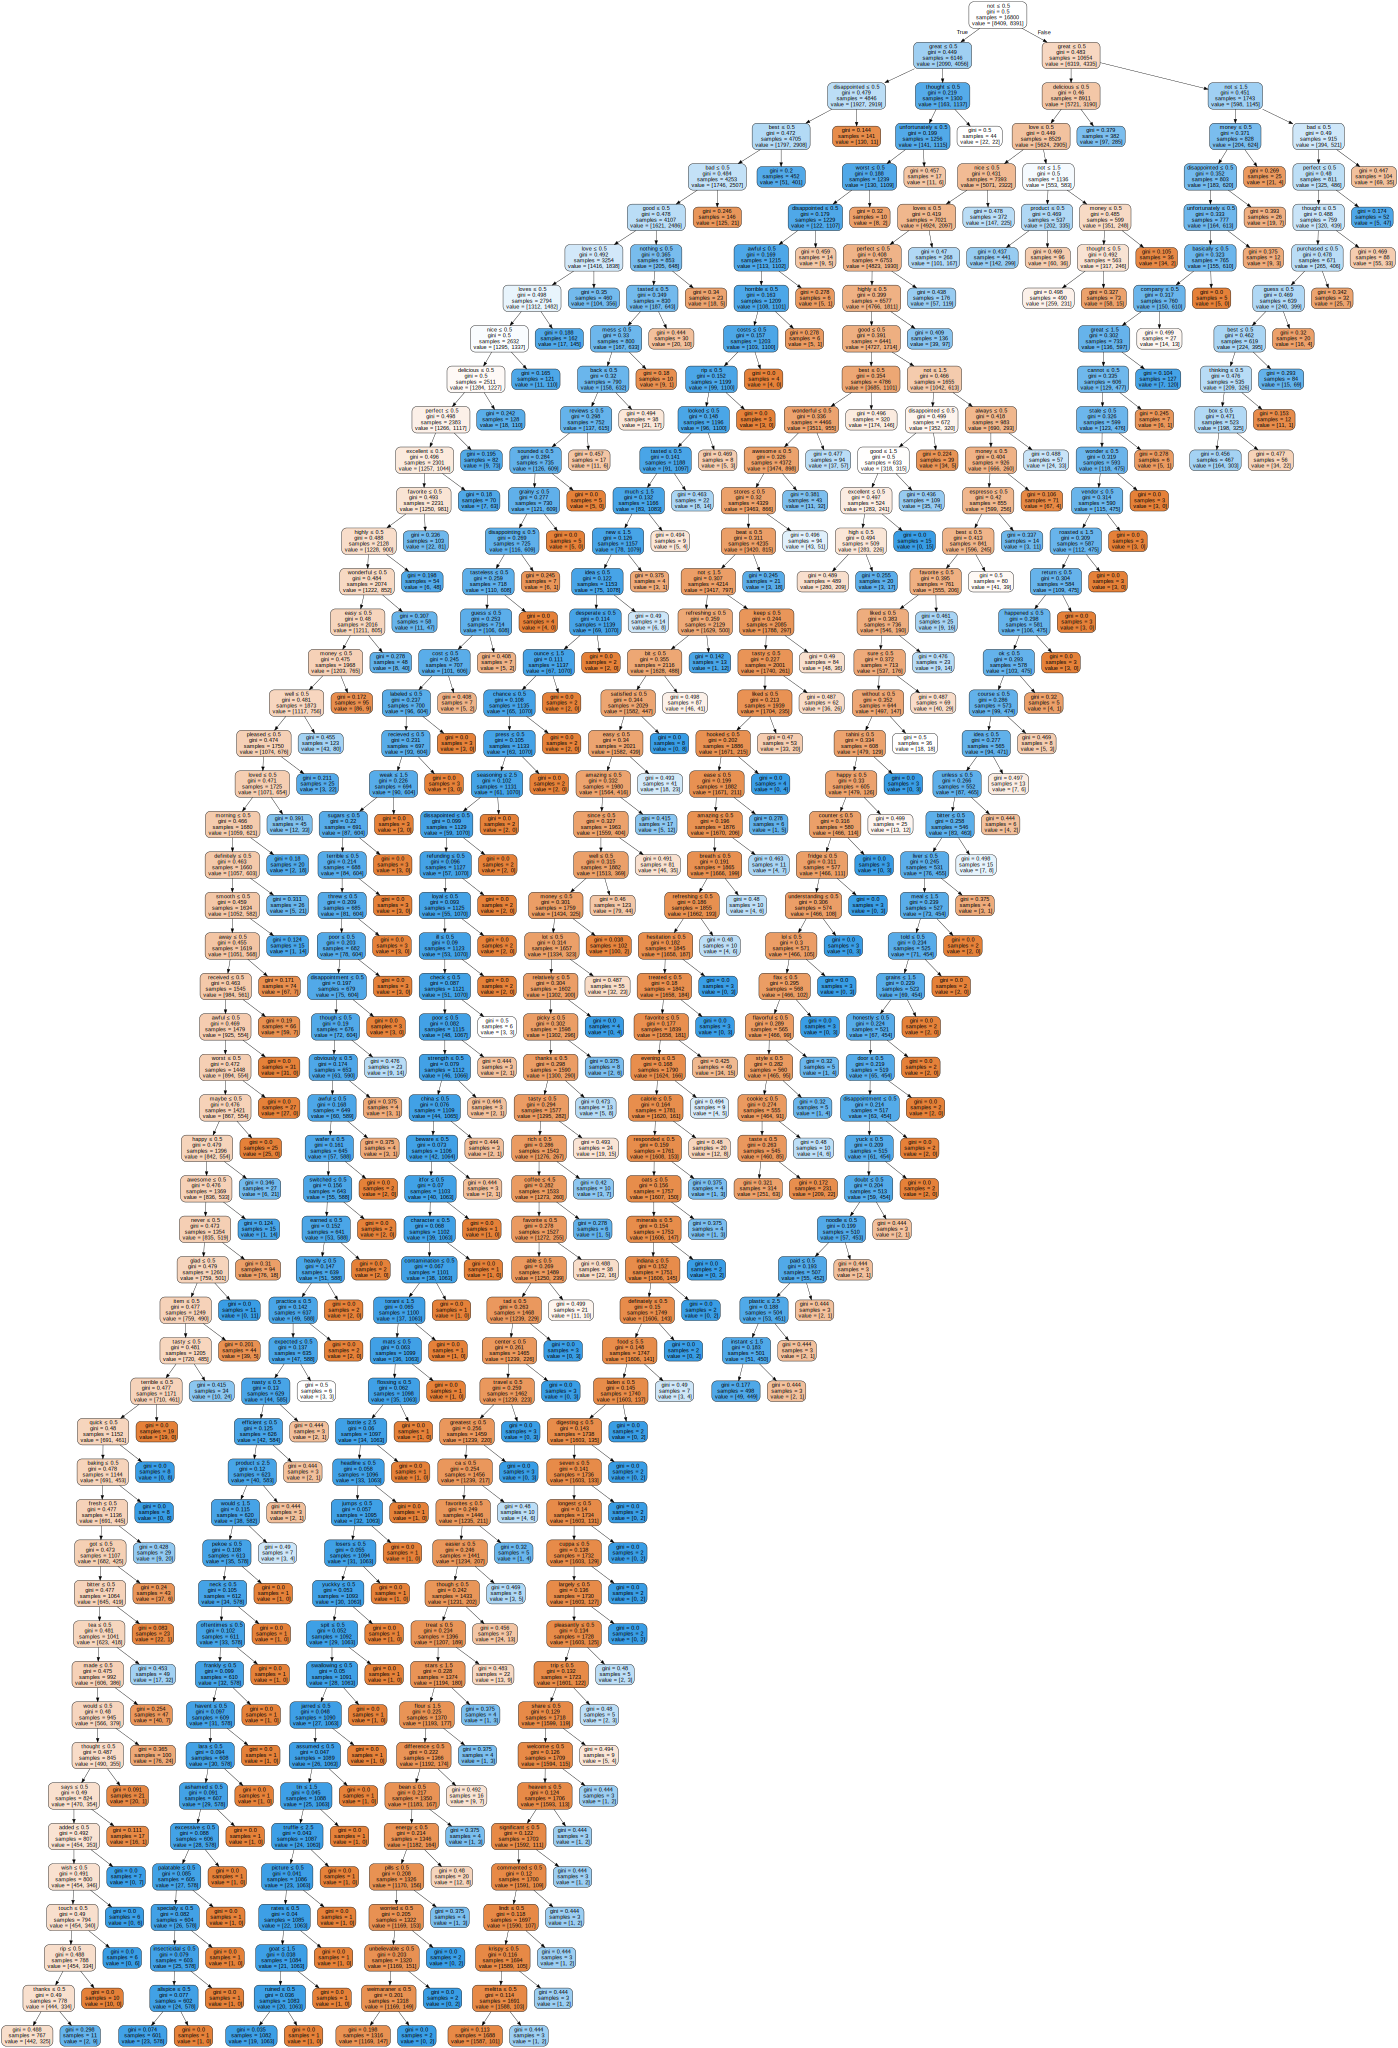

In [42]:
import graphviz
dot_data = tree.export_graphviz(clfg, out_file=None, 
                      feature_names=countvec.get_feature_names(),filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


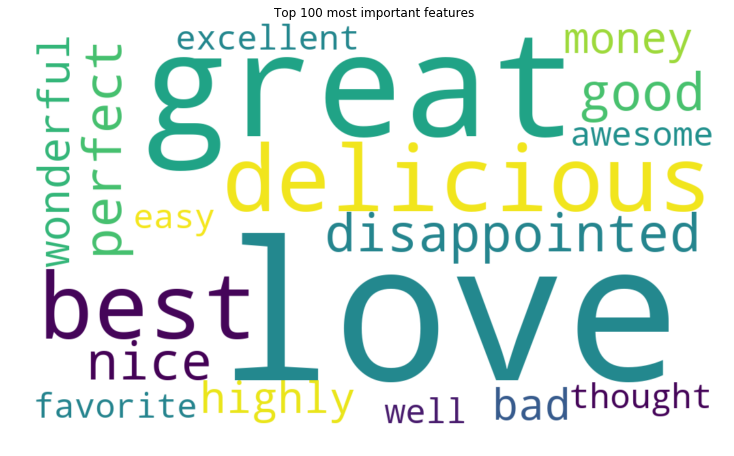

In [45]:
from wordcloud import WordCloud, STOPWORDS

features = countvec.get_feature_names()
coef = clfg.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:20]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show()